# PreProcess the Churn Dataset

In [146]:
# imports
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import importlib
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import confusion_matrix,f1_score, roc_auc_score, average_precision_score, precision_score,recall_score 

import majorityVoting as maj
import logisticRegression as lgr
import metrics_class as met

class_weight = None


importlib.reload(lgr)
importlib.reload(maj)
importlib.reload(met)



<module 'metrics_class' from '/media/tanveer/sda5/L4-T2/CSE 472 - Machine Learning Sessional/Offline 2/Solution/Preprocessors/metrics_class.py'>

In [147]:
# Resampling
def custom_resample(x, y, proportion=1.0, seed = 42):
    """
    Custom function to perform bootstrapping
    """
    np.random.seed(seed)  # Ensure reproducibility
    # sample with replacement

    indices = np.random.choice(np.arange(len(x)), size=int(proportion*len(x)), replace=True)

    # iloc - index the dataframe and reset the index
    x_sampled = x.iloc[indices].reset_index(drop=True)
    y_sampled = y[indices]

    return x_sampled, y_sampled

# create and return bagging models
def create_bagging_models(x_train, y_train, num_models=9, learning_rate=.01, no_itr=1500, class_weight=None):
    """
        x_train: Pandas Dataframe
        y_train: Pandas DataFrame 
    """
    models = []
    for i in range (num_models):
        x_resampled, y_resampled = custom_resample(x_train, y_train, seed=44+i)
        
        if class_weight:
            model = lgr.CustomLogisticRegression(learning_rate = learning_rate, num_iterations= no_itr, class_weight=class_weight)
        else:
            model = lgr.CustomLogisticRegression(num_iterations=no_itr, learning_rate=learning_rate)
            
        model.custom_fit(x_resampled, y_resampled)
        # model = LogisticRegression()
        # model.fit(x_resampled, y_resampled)
        models.append(model)

    return models

# return the predictions from the bagging models
def get_predictions_from_bagged_models(models, x):
    """
        get predictions from a list of models against the input data X
        
        X: pandas dataframe
    """
    return np.array([model.custom_predict(x) for model in models]).T

# augment the predictions to the validation set
def augment_predictions_to_validation_set(models, x_validation):
    """
        Augment the results got against the validation set from the models 

        Returns: 
            Augmented Pandas DataFrame 
    """
    model_predictions = get_predictions_from_bagged_models(models, x_validation)

    # create columns
    cols = [f'model_{i+1}' for i in range(model_predictions.shape[1])]

    x_validation_df = pd.DataFrame(x_validation)
    model_predictions_df = pd.DataFrame(model_predictions, columns=cols)


    augmented_validation_df = pd.concat([x_validation_df, model_predictions_df], axis=1)

    return augmented_validation_df

# train the meta classifier
def train_meta_classifier(augmented_validation_df, y_validation,learning_rate = .01, no_itr=1500, class_weight=None):
    """
        augmented_validation_df : 
            augmented validation dataframe as features
        y_validation: 
            y values of validation set as target
        learning rate: 
            for setting up the model
        no_itr:
            for the model
        class_weight:
            for imbalanced dataset
        return the meta classifier that is trained using the augmented validation set 
    """
    if class_weight:
        meta_model = lgr.CustomLogisticRegression(learning_rate=learning_rate, num_iterations = no_itr, class_weight=class_weight)
    else:
        meta_model = lgr.CustomLogisticRegression(learning_rate=learning_rate, num_iterations = no_itr)

    meta_model.custom_fit(augmented_validation_df, y_validation)
    return meta_model

    

In [148]:
# drop the duplicated rows
def drop_duplicates(dataframe):
    dataframe.drop_duplicates(inplace=True)
    return dataframe

# separate the data frame into features and target
def create_feature_target(dataframe, column=''):
    features = dataframe.drop(column, axis=1)
    target = dataframe[column]
    return features, target

# label encode the target
def label_encoding_target_helper(target, cols=[]):
    le = LabelEncoder()
    target = le.fit_transform(target.values.ravel())
    target = pd.DataFrame(target, columns=cols)
    return target

# label encode the feature
def label_encoding_features_helper(features):
    # Label Encode binary columns
    binary_cols = [c for c in features.columns if features[c].dtype not in ['int64', 'float64'] and features[c].nunique() == 2]
    binary_cols
    le = LabelEncoder()

    for c in binary_cols:
        features[c] = le.fit_transform(features[c])

    return features

# one hot encoding
def one_hot_helper(features):
    # OneHot encoding
    object_cols = features.select_dtypes(include=['object']).columns


    # chage the datatype to category
    for c in object_cols:
        features[c] = features[c].astype('category')

    features = pd.get_dummies(features)
    features = features.astype('int')
    return features

# scaling helper
def scaling_helper(features, scaler='minmax'):
    # we separate the binary cols
    binary_cols = [c for c in features.columns if features[c].nunique() == 2]

    binary_features = features[binary_cols]
    continous_features = features.drop(columns=binary_cols)

    if scaler == 'standard':
        scaler = StandardScaler()
    else:
        scaler = MinMaxScaler()
    
    scaled_features = scaler.fit_transform(continous_features)
    continous_features = pd.DataFrame(scaled_features, columns=continous_features.columns)

    # reset the index
    binary_features.reset_index(drop=True, inplace=True)

    #concat the two matrices
    features = pd.concat([binary_features,continous_features], axis=1)
    return features

# correlation helper
def correlation_helper(features, target, target_col_name):
    target_series = target[target_col_name]
    correlations = features.corrwith(target_series)
    return pd.DataFrame({'Feature': correlations.index, 'Correlation': correlations.values})

def information_gain_helper(features, target):
    mi = mutual_info_classif(features,target)
    return pd.DataFrame({'Feature': features.columns, 'Information Gain': mi})

def get_top_features(correlations, info_gain, top=40):
    # Combine DataFrames
    combined_df = info_gain.merge(correlations, on='Feature', how='inner')
    
    # Calculate a combined score based on absolute values
    combined_df['Absolute Info Gain'] = combined_df['Information Gain'].abs()
    combined_df['Absolute Correlation'] = combined_df['Correlation'].abs()
    combined_df['Combined Score'] = combined_df['Absolute Info Gain'] + combined_df['Absolute Correlation']
    
    # Sort by combined score
    combined_df = combined_df.sort_values(by='Combined Score', ascending=False)
    
    #return the top features
    return combined_df.head(top)['Feature'] 


# Data splitter
def split_data(features, target, test_size=0.2, random_state=42):
    
    # Check if the target is a pandas DataFrame/Series
    if isinstance(target, pd.DataFrame) or isinstance(target, pd.Series):
        target = target.values.ravel()  # Convert to 1D numpy array
    
    # If it's already a numpy array and has more than 1 dimension, flatten it
    elif isinstance(target, np.ndarray) and target.ndim > 1:
        target = target.ravel()
    
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=test_size, random_state=random_state)
    

    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = pd.Series(y_train).reset_index(drop=True).to_numpy().ravel()
    y_test = pd.Series(y_test).reset_index(drop=True).to_numpy().ravel()

    return X_train, X_test, y_train, y_test


In [149]:

## Individual performance metrics
def custom_accuracy(y_true, y_pred):
    cor_pred = np.sum(y_true == y_pred)
    tot_samp = len(y_pred)

    return cor_pred/tot_samp
    

def custom_precision(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    tp = np.sum((y_true==1) & (y_pred==1))
    fp = np.sum((y_true==0) & (y_pred==1))

    return tp/(tp+fp) if (tp+fp)>0 else 0

def custom_sensitivity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    return tp/(tp+fn) if (tp+fn)>0 else 0

def custom_specificity(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    tn = np.sum((y_true==0) & (y_pred==0))
    fp = np.sum((y_true==0) & (y_pred==1))

    return tn/(tn+fp) if (tn+fp)>0 else 0


def f1_score_(y_true, y_pred):
    return f1_score(y_true, y_pred)

def auroc(y_true, y_pred):
    return roc_auc_score(y_true, y_pred)

def aupr(y_true, y_pred):
    return average_precision_score(y_true, y_pred)


In [150]:
# metrics for all the 9 LR models
def lr_metric_calculator(models, X_test, y_test,threshold=0.5):
    
    lr_metrics = met.Metrics()

    # predict the models against the 'X_test' and update the performance metrics
    for model in models:
        y_pred = model.custom_predict(X_test, threshold=threshold)
        # y_pred = model.predict(X_test)
        lr_metrics.update_the_metrics(y_test, y_pred)

    return lr_metrics

# for the stacking metrics
def stacking_metric_calculator(model, X_test, y_test, threshold=0.5):
    
    st_metrics = met.Metrics()

    # predict the model against the 'X_test' and update the performance metrics
    
    y_pred = model.custom_predict(X_test, threshold=threshold)
    st_metrics.update_the_metrics(y_test, y_pred)

    return st_metrics

# for majority voting
def voting_metric_calculator(model, X_test, y_test):
    
    vt_metrics = met.Metrics()

    # predict the model against the 'X_test' and update the performance metrics
    
    y_pred = model.custom_prediction(X_test)
    vt_metrics.update_the_metrics(y_test, y_pred)

    return vt_metrics

# plot the violin plot
def plot_violin(lr_metrics_data):
    # Plotting the violin plots for each metric
    plt.figure(figsize=(15, 10))

    for i, (metric_name, values) in enumerate(lr_metrics_data.metrics.items(), 1):
        plt.subplot(3, 3, i)
        sns.violinplot(data=[values], inner="point")
        plt.title(f'Violin plot of {metric_name}')
        plt.ylabel('Score')

    plt.tight_layout()
    plt.show()

In [151]:
# read the csv file
dataframe = pd.read_csv("../Program_Data/churn.csv")
dataframe


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [152]:
# remove the customer Id column from the dataset
dataframe = dataframe.drop('customerID', axis=1)
dataframe

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [153]:
# Count the number of missing values
dataframe.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [154]:
'''
because of space in some cell of the TotalCharges column,
the datatype of the column has changed to Object

Convert the space filled cells with NaN 
then convert the whole column to numeric
find the mean of the column
fill the NaN with the mean

'''

dataframe['TotalCharges'] = dataframe['TotalCharges'].replace(' ', np.nan)

dataframe['TotalCharges'] = pd.to_numeric(dataframe['TotalCharges'], errors='coerce')

mean = dataframe['TotalCharges'].mean()

dataframe['TotalCharges'] = dataframe['TotalCharges'].fillna(mean)

dataframe['TotalCharges'].dtype


dtype('float64')

In [155]:
# the number of duplicated rows
dataframe.duplicated().sum()

np.int64(22)

# Data cleaning

In [156]:
# view the duplicates
# dataframe[dataframe.duplicated(keep=False)]

# remove the duplicated rows

dataframe.drop_duplicates(inplace=True)

dataframe


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes


# Create input and output features

In [157]:
# dataframe.columns
features = dataframe.drop('Churn', axis=1)
target = dataframe['Churn']


# Encoding

In [158]:
# Labelencode target 
target = label_encoding_target_helper(target, ['Churn'])
target

,Churn
0,0
1,0
2,1
3,0
4,1
...,...
7016,0
7017,0
7018,0
7019,1


In [159]:
# Label Encode binary columns
features = label_encoding_features_helper(features)

features.dtypes


gender                int64
SeniorCitizen         int64
Partner               int64
Dependents            int64
tenure                int64
PhoneService          int64
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling      int64
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
dtype: object

In [160]:
# OneHot encoding
features = one_hot_helper(features)
features

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,MultipleLines_No,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29,29,0,...,1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,34,1,0,56,1889,1,...,1,0,0,0,1,0,0,0,0,1
2,1,0,0,0,2,1,1,53,108,1,...,1,0,0,1,0,0,0,0,0,1
3,1,0,0,0,45,0,0,42,1840,0,...,1,0,0,0,1,0,1,0,0,0
4,0,0,0,0,2,1,1,70,151,1,...,1,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,1,1,24,1,1,84,1990,0,...,0,0,1,0,1,0,0,0,0,1
7039,0,0,1,1,72,1,1,103,7362,0,...,0,0,1,0,1,0,0,1,0,0
7040,0,0,1,1,11,0,1,29,346,0,...,1,0,0,1,0,0,0,0,1,0
7041,1,1,1,0,4,1,1,74,306,0,...,1,0,0,1,0,0,0,0,0,1


# Scaling 

In [161]:
features = scaling_helper(features)
features


,gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,...,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure,MonthlyCharges,TotalCharges
0,0,0,1,0,0,1,0,1,0,1,...,1,0,0,0,0,1,0,0.013889,0.11,0.001269
1,1,0,0,0,1,0,1,0,0,1,...,0,1,0,0,0,0,1,0.472222,0.38,0.215901
2,1,0,0,0,1,1,1,0,0,1,...,1,0,0,0,0,0,1,0.027778,0.35,0.010385
3,1,0,0,0,0,0,0,1,0,1,...,0,1,0,1,0,0,0,0.625000,0.24,0.210247
4,0,0,0,0,1,1,1,0,0,0,...,1,0,0,0,0,1,0,0.027778,0.52,0.015347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7016,1,0,1,1,1,1,0,0,1,1,...,0,1,0,0,0,0,1,0.333333,0.66,0.227556
7017,0,0,1,1,1,1,0,0,1,0,...,0,1,0,0,1,0,0,1.000000,0.85,0.847450
7018,0,0,1,1,0,1,0,1,0,1,...,1,0,0,0,0,1,0,0.152778,0.11,0.037849
7019,1,1,1,0,1,1,0,0,1,0,...,1,0,0,0,0,0,1,0.055556,0.56,0.033233


# Correlation Analysis


In [162]:
correlations = correlation_helper(features, target, 'Churn')
correlations

,Feature,Correlation
0,gender,-0.008763
1,SeniorCitizen,0.151619
2,Partner,-0.149135
3,Dependents,-0.163459
4,PhoneService,0.011323
5,PaperlessBilling,0.190891
6,MultipleLines_No,-0.034782
7,MultipleLines_No phone service,-0.011323
8,MultipleLines_Yes,0.041958
9,InternetService_DSL,-0.124223


# Validating the pipeline

In [163]:
# Step 1: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target.values.ravel(), test_size=0.2, random_state=42)

# Step 2: Initialize the Logistic Regression classifier
clf = LogisticRegression()

# Step 3: Train the classifier on the training data
clf.fit(X_train, y_train)

# Step 4: Make predictions on 
# the test set
y_pred = clf.predict(X_test)

# Step 5: Evaluate the classifier's performance
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='binary')
print(f"Accuracy of Logistic Regression classifier: {accuracy:.2f}")
print(f"sensitivity of Logistic Regression classifier: {recall:.2f}")



Accuracy of Logistic Regression classifier: 0.80
sensitivity of Logistic Regression classifier: 0.54


### Using the Custom Classifiers


In [164]:
# the data is not splitted, so split data as 80% train and 20% test
X_train, X_test, y_train, y_test = split_data(features, target)


# split the train data into 80% train and 20% validation
X_train, X_validation, y_train, y_validation = split_data(X_train, y_train)

print(X_train.shape)
print(X_validation.shape)


(4492, 40)
(1124, 40)


### create the nine LR models with the bagged samples

In [165]:
models =  create_bagging_models(X_train, y_train, learning_rate=.01, no_itr=2500)

### Metrics calculation for the nine LR models against the test_set

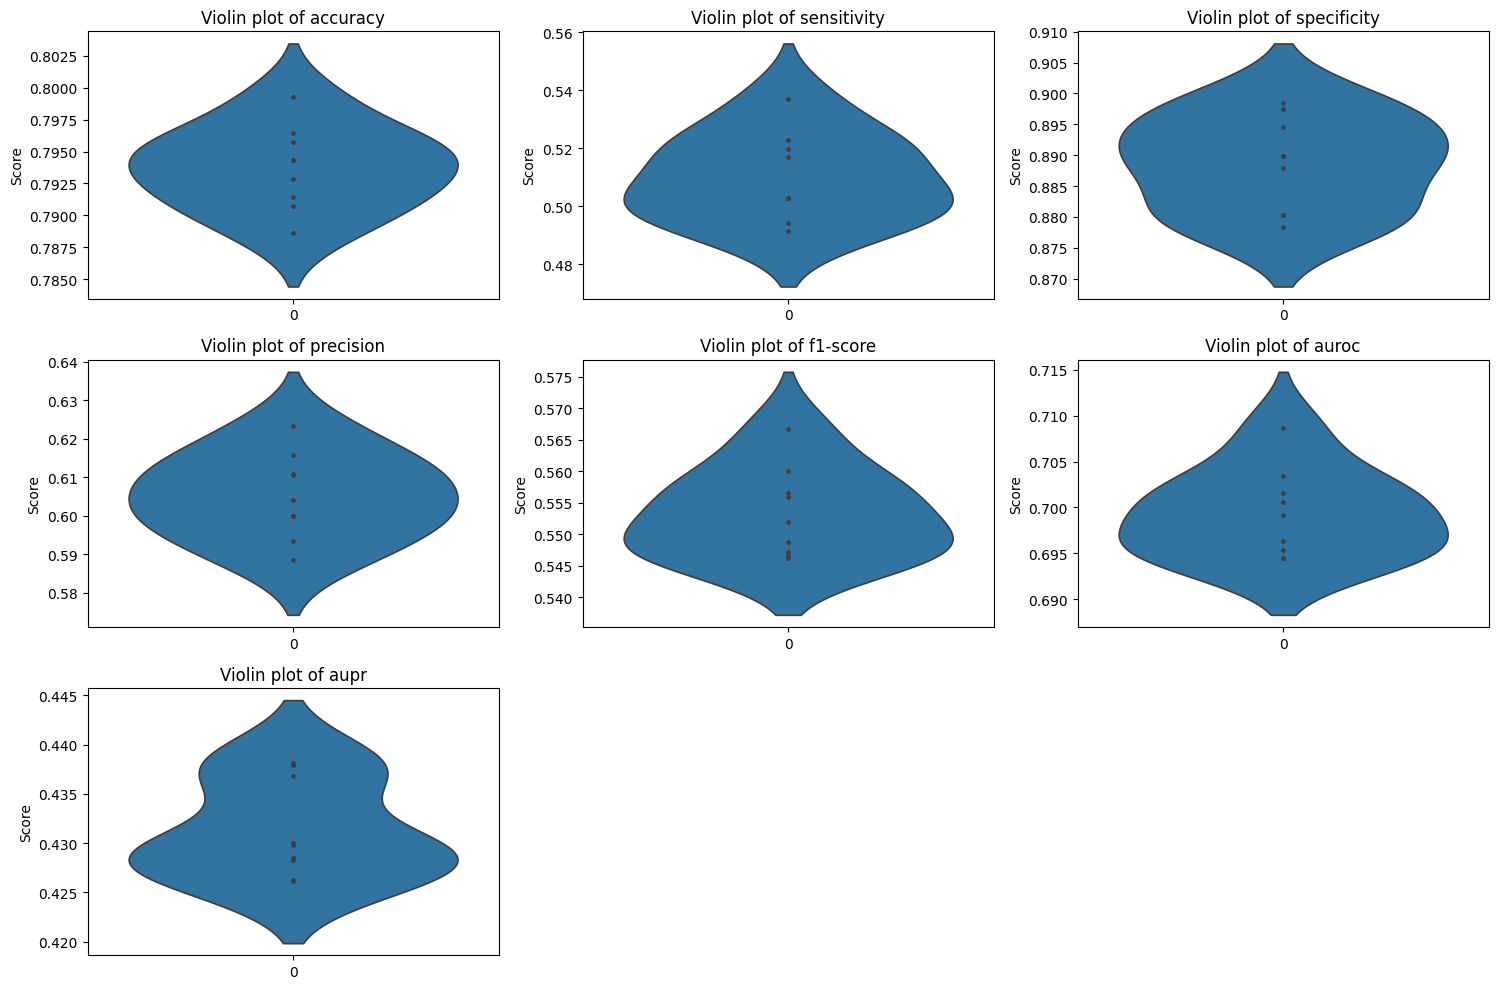

In [166]:

# create the metrics for LR
lr_metrics = lr_metric_calculator(models, X_test, y_test, threshold=0.5)

plot_violin(lr_metrics)



### The mean Metrics

In [167]:

# find the mean+stddev for each of the metric in lr_metrices
lr_metrics.calculate_mean_stddev()

# view the matrices
lr_metrics.print_()


accuracy : [np.float64(0.796805102264234)]
sensitivity : [np.float64(0.5241539326322929)]
specificity : [np.float64(0.8956648801843646)]
precision : [np.float64(0.615498453354733)]
f1-score : [np.float64(0.5599791868255699)]
auroc : [np.float64(0.7038343806465315)]
aupr : [np.float64(0.4359676077253143)]


### Stacking

In [168]:

# The models are already trained
# augment the result that achieved against the validation set with the validation set

augmented_validation_df =  augment_predictions_to_validation_set(models, X_validation)
augmented_validation_df


,gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,...,TotalCharges,model_1,model_2,model_3,model_4,model_5,model_6,model_7,model_8,model_9
0,1,1,1,0,1,1,0,0,1,0,...,0.734364,0,0,0,0,0,0,0,0,0
1,1,0,1,0,1,1,0,0,1,0,...,0.916686,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,1,0,...,0.355181,1,1,1,1,1,1,1,1,1
3,1,0,1,0,1,0,0,0,1,0,...,0.180591,0,0,0,0,0,0,0,0,0
4,0,1,0,0,1,1,0,0,1,0,...,0.085853,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1119,0,0,1,0,1,1,0,0,1,0,...,0.788253,0,0,0,0,0,0,0,0,0
1120,0,0,1,1,1,0,0,0,1,1,...,0.507385,0,0,0,0,0,0,0,0,0
1121,1,1,1,0,1,1,0,0,1,0,...,0.008885,1,1,1,1,1,1,1,1,1
1122,1,0,0,0,1,0,1,0,0,0,...,0.000115,0,0,0,0,0,0,0,0,0


In [169]:
# train the meta-Classifier-Model
meta_classifier_model =  train_meta_classifier(augmented_validation_df, y_validation, learning_rate=0.01, no_itr=2500)

In [170]:
# prepare the test data
# for prediction the test data need to have the same columns as the trained data
# So we also need to augment to the test_set, The results
augmented_test_df =  augment_predictions_to_validation_set(models, X_test)
augmented_test_df

,gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,...,TotalCharges,model_1,model_2,model_3,model_4,model_5,model_6,model_7,model_8,model_9
0,1,0,1,1,1,1,1,0,0,0,...,0.202862,1,1,1,1,1,1,1,1,1
1,1,0,1,1,1,1,0,0,1,0,...,0.565313,0,0,0,0,0,0,0,0,0
2,1,1,0,0,1,1,0,0,1,0,...,0.902492,0,0,0,0,0,0,0,0,0
3,0,0,1,0,1,0,1,0,0,0,...,0.126587,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,1,0,1,...,0.001269,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1400,0,0,1,0,1,0,0,0,1,1,...,0.431341,0,0,0,0,0,0,0,0,0
1401,0,0,1,1,1,0,1,0,0,0,...,0.029310,0,0,0,0,0,0,0,0,0
1402,0,0,1,0,0,1,0,1,0,1,...,0.495269,0,0,0,0,0,0,0,0,0
1403,0,0,1,0,1,1,1,0,0,1,...,0.435380,0,0,0,0,0,0,0,0,0


In [171]:
#  metric calculation for Stack Models

stack_metrics = stacking_metric_calculator(meta_classifier_model, augmented_test_df, y_test, threshold=0.5)

stack_metrics.print_()



accuracy : [np.float64(0.7921708185053381)]
sensitivity : [np.float64(0.5369318181818182)]
specificity : [np.float64(0.8774928774928775)]
precision : [np.float64(0.5943396226415094)]
f1-score : [np.float64(0.564179104477612)]
auroc : [np.float64(0.707212347837348)]
aupr : [np.float64(0.43513408907784623)]


### Majority Voting

In [172]:
# metric calculation for majority voting

voter = maj.MajorityVoting(models)

vt_metrics = voting_metric_calculator(voter, X_test, y_test)

vt_metrics.print_()


accuracy : [np.float64(0.795017793594306)]
sensitivity : [np.float64(0.5028409090909091)]
specificity : [np.float64(0.8926875593542261)]
precision : [np.float64(0.6103448275862069)]
f1-score : [np.float64(0.5514018691588785)]
auroc : [np.float64(0.6977642342225676)]
aupr : [np.float64(0.43146150810473116)]


In [173]:
comparison_data = {
    'Metric': ['Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'F1-Score', 'AUROC', 'AUPR'],
    'Logistic Regression': lr_metrics.get_metrics_summary().values(),
    'Voting Ensemble': vt_metrics.get_metrics_summary().values(),
    'Stacking Ensemble': stack_metrics.get_metrics_summary().values()
}

comparison_df = pd.DataFrame(comparison_data).set_index('Metric').transpose()

comparison_df

Metric,Accuracy,Sensitivity,Specificity,Precision,F1-Score,AUROC,AUPR
Logistic Regression,0.796805,0.524154,0.895665,0.615498,0.559979,0.703834,0.435968
Voting Ensemble,0.795018,0.502841,0.892688,0.610345,0.551402,0.697764,0.431462
Stacking Ensemble,0.792171,0.536932,0.877493,0.594340,0.564179,0.707212,0.435134
